### In this notebook, I will look at different signals and some basic features that can be extracted. I will analyze their relationship with the "time before the event" and choose the ones, that seem to have most predictive power.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import h5py
import time
import random
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.colors as colors

## Functions

In [146]:
#Basic statistical quantities not provided in numpy
def rms(sample): #For our time series, the mean is very close to 0, so this is equal to standard deviation in that case.
    return math.sqrt(sum([x**2 for x in sample]))/math.sqrt(len(sample))

def extr(sample): 
    mn=abs(min(sample))
    mx=max(sample)
    if mn>mx:
        return mn
    else:
        return mx

#Correlations
def cross_cor(sample1,sample2): #The returned vector has len(sample1)+len(sample2)-1
    return np.correlate(sample1,sample2,"full")

def auto_cor(sample): #Here, it is len(sample)
    res=np.correlate(sample,sample,"full")
    return res[len(sample)-1:]


#Time-consuming features not explored here.    
def approx_entropy(sample,m,r): #Apparently very useful parameter to measure randomness of data, however calculating it
                                #for data of length>1000 (i.e. for a single vector of len>1000) takes very long time. 
                                #Check https://en.wikipedia.org/wiki/Approximate_entropy
    def maxdist(x_i, x_j):
        return max(abs(np.subtract(x_i,x_j)))

    def phi(m):

        x = [[sample[j] for j in range(i, i + m)] for i in range(N - m + 1)]

        C = [len([1 for x_j in x if maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]

        print('here')

        return sum(np.log(C))/(N - m + 1.0)

    N = len(sample)

    return abs(phi(m+1) - phi(m))

def ARIMA_fit(sample,p,d,q):  #Fitting to model https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model
                              #Fitting takes a lot of time, and it is not obvious what parameters (p,d,q) to use. (5,0,1)
                              #worked for me for most data, not for all. There seems to be some weak correlation between
                              #2, maybe 3, of the 6 fitted parameters and time to event.
    model=ARIMA(sample,order=(p,d,q))
    fit=model.fit(disp=0)
    return fit.arparams,fit.maparams



#Filters and corrections:
def flatten_cor(data,window=10): #Function to normalize auto- and cross-correlation

    temp=[0]*len(data)
    for i in range(len(data)):
        temp[i]=data[i]-mean(data[max(0,int(i-window/2)):min(len(data),int(i+window/2))])
    return temp

def MA(lst,N=20): #Moving average
    return np.divide(np.convolve(lst,np.ones(N,),"valid"),N)


def normalize(data): #Bringing data to (X-mu)/S form
    return np.divide(np.subtract(data,np.mean(data)),np.std(data))


#FFT
def FFT(sample): #Simply real part of the FFT 
    fft_example=np.fft.rfft(sample)
    fft_example.real[0]=0
    return fft_example.real[:]

def logPSD(sample,N=15):        #Power Spectrum Density, i.e. absolute value of the FFT showing how much "power" is in certain 
    fftF=np.fft.rfft(sample)   #frequency. I smooth it with moving average (data is very noisy) and take log base 10 (values
    fftF[0]=0                  #vary over many orders of magnitude).

    return np.log10(MA(np.absolute(fftF),N))


#Other feature functions    
def peak_no(sample,threshold,window=2000): #Number of peaks 
    count=0
    step=0
    for i in range(len(sample)):
        if step>0:
            step-=1
            continue
        if sample[i]>threshold:
            count+=1
            step=window
            
    return count

#Samples are saved in an hdf5 file. This function gets the time series and the "time until event" value.
def get_sample(i):
    f=h5py.File("samples_full.hdf5","r")
    samp=f['Samples']
    time=f['Time']
    
    return samp[i,:],time[i]


---

# Data Exploration

Let's load all samples, instead of using the "get_sample" function. The file contains total of about 14000 instances of 150,000-point long time series data together with time until the event. The time series represents seismological data as a function of time until the earthquake (obtained through an expermiental simulation of an earthquake). These time series were then cut into 150,000-long chunks. The time associated with every time-series is time until the event from the end of the time series.

In [20]:
fw=h5py.File("samples_full.hdf5","r")
P=fw["Samples"]
T=fw["Time"]
N=len(T)

## Example of different time-series we have to deal with

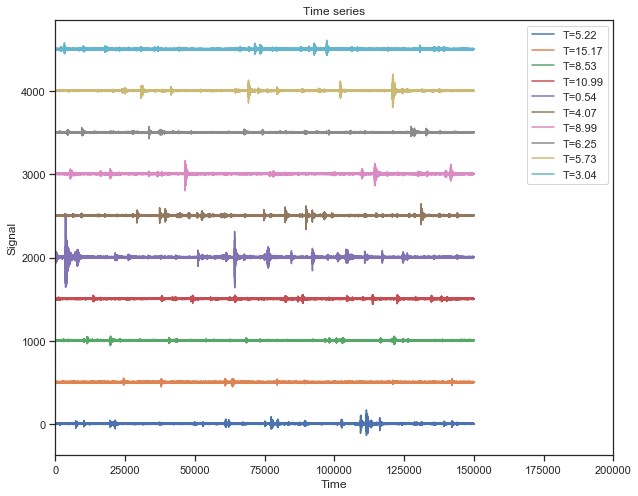

In [30]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

inds=np.random.choice(N, 10, replace=False)

for i in range(10):
    sample=P[inds[i]]
    ax.plot(sample+i*500,label="T={:.2f}".format(T[inds[i]]))
    
ax.set_xlabel("Time")
ax.set_ylabel("Signal")
ax.set_title("Time series")
ax.set_xlim(0,200000)
ax.legend(loc=1)

## Basic features

We select a sample from all the time-series. It will be sufficient to see any easy-to-spot correlations.

In [39]:
N_sample=1000
sample_inds=np.random.choice(N,N_sample,replace=False)
P_sample=[]
T_sample=[]
for index in sample_inds:
    P_sample.append(P[index])
    T_sample.append(T[index])

In [41]:
STDs=np.std(P_sample,axis=1)
EX=np.zeros((N_sample,))

for i in range(N_sample):
    EX[i]=extr(P_sample[i])


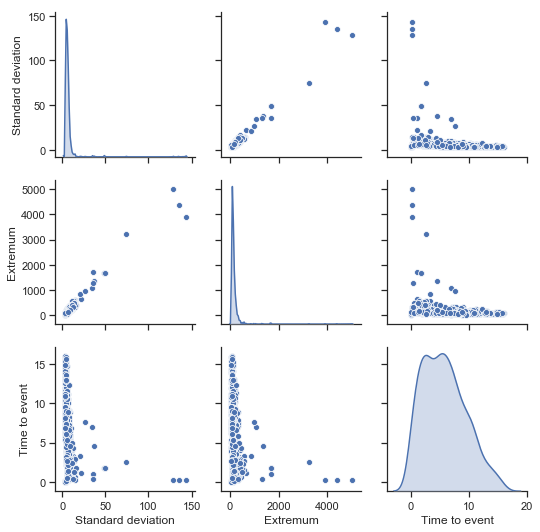

In [46]:
d = {"Standard deviation":STDs,"Extremum":EX,"Time to event":T_sample}
df = pd.DataFrame(data=d)
g=sns.pairplot(df,diag_kind="kde")

Unsuprisingly, extremum and the standard deviation are almost identical. Let's plot both of them versus the time with some of the outliers removed.

Text(0.5, 0, 'Time to event')

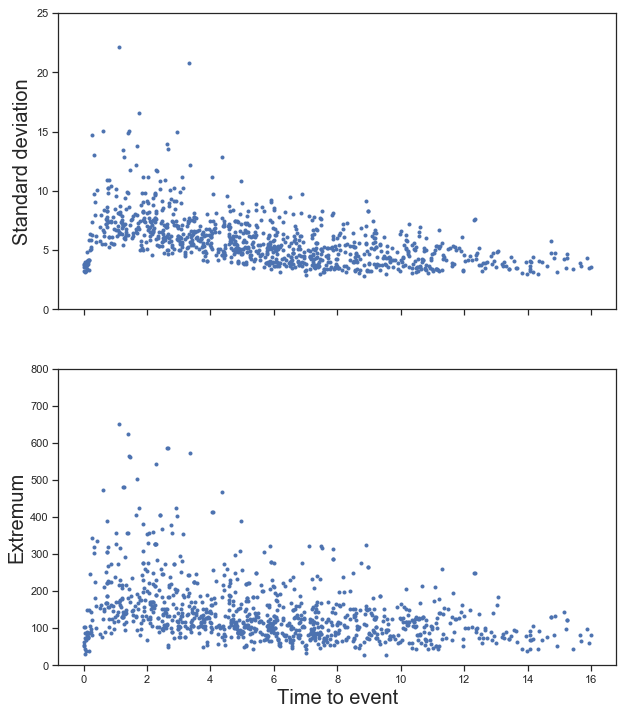

In [51]:
fig,(ax1,ax2)=plt.subplots(2,1,sharex=True,figsize=(10,12))

ax1.plot(T_sample,STDs,'.')
ax1.set_ylim((0,25))
ax1.set_ylabel('Standard deviation',fontsize=20)

ax2.plot(T_sample,EX,'.')
ax2.set_ylim((0,800))
ax2.set_ylabel('Extremum',fontsize=20)
ax2.set_xlabel('Time to event',fontsize=20)

While both are very similar, the standard deviation seems to have a clearer relationship. We also notice that for small times T, the features somewhat belong to a separate category. 

We expect autocorrelations to behave almost identically - indeed autocorrelation with small delta t is basically standard devaition squared in this case (mean=0).

## Fourier Transform

First, let's look at FFTs of some signals

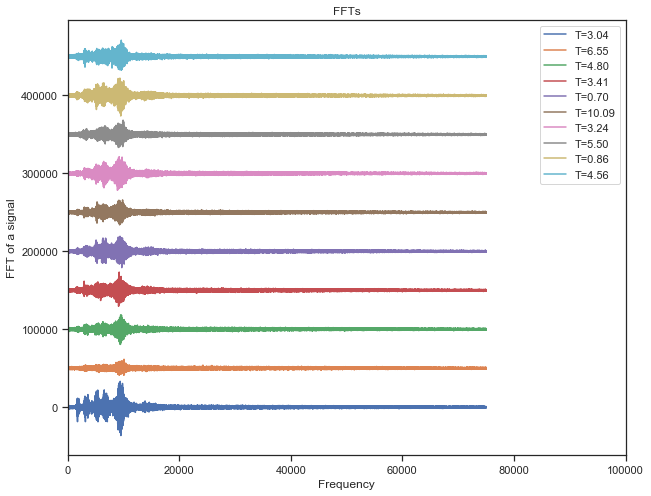

In [57]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

inds=np.random.choice(N, 10, replace=False)

for i in range(10):
    sample=FFT(P[inds[i]])
    ax.plot(sample+i*50000,label="T={:.2f}".format(T[inds[i]]))
    
ax.set_xlabel("Frequency")
ax.set_ylabel("FFT of a signal")
ax.set_title("FFTs")
ax.set_xlim(0,100000)
ax.legend(loc=1)

Clearly, the low-frequency components are of interest here. From now on we will use f=20000 as out limiting frequency.

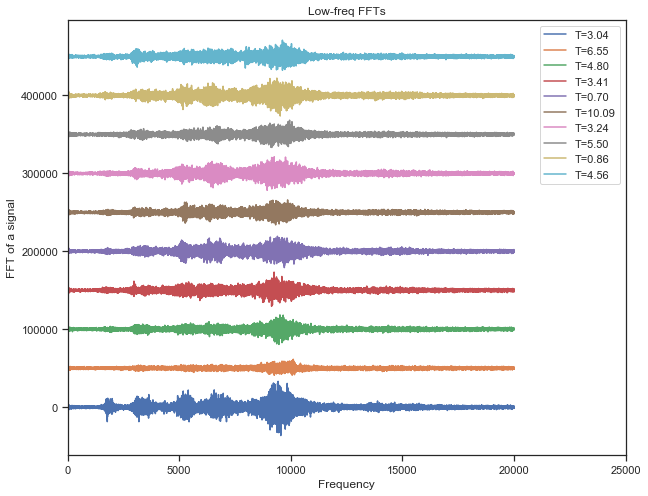

In [58]:
f_lim=20000
fig, ax = plt.subplots(1,1,figsize=(10,8))


for i in range(10):
    sample=FFT(P[inds[i]])
    ax.plot(sample[:f_lim]+i*50000,label="T={:.2f}".format(T[inds[i]]))
    
ax.set_xlabel("Frequency")
ax.set_ylabel("FFT of a signal")
ax.set_title("Low-freq FFTs")
ax.set_xlim(0,25000)
ax.legend(loc=1)

To analyze the FFTs, it is better to look at the power spectrum density

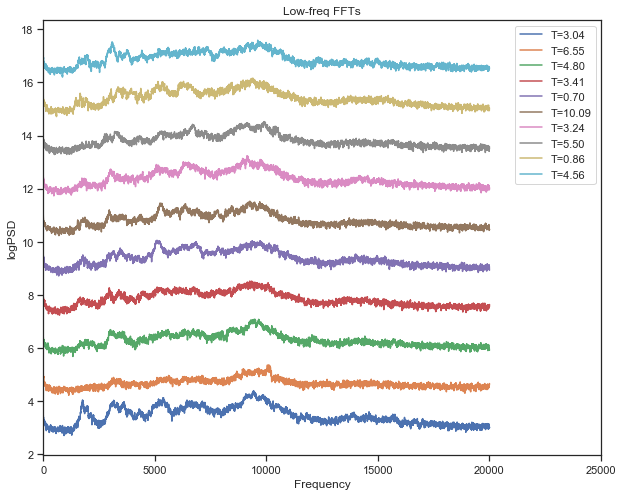

In [62]:
fig, ax = plt.subplots(1,1,figsize=(10,8))


for i in range(10):
    sample=logPSD(P[inds[i]])
    ax.plot(sample[:f_lim]+1.5*i,label="T={:.2f}".format(T[inds[i]]))
    
ax.set_xlabel("Frequency")
ax.set_ylabel("logPSD")
ax.set_title("Low-freq FFTs")
ax.set_xlim(0,25000)
ax.legend(loc=1)

The spectra seem quite similar for now, but let's look at total "power" in it and how it relates to T.

In [64]:
PSDs=np.zeros((N_sample,))

for i in range(N_sample):
    PSDs[i]=rms(logPSD(P_sample[i])[:f_lim])

Text(0.5, 0, 'Time to event')

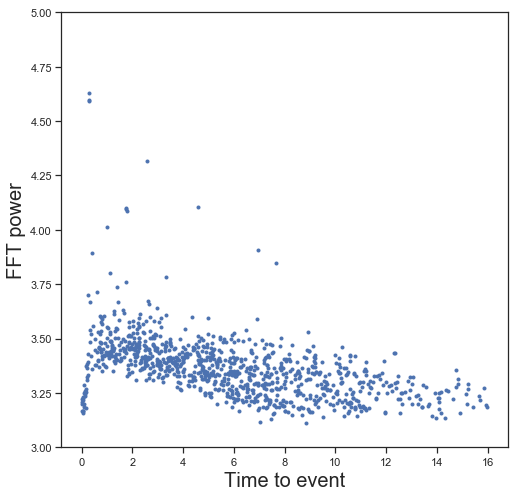

In [67]:
fig,ax1=plt.subplots(1,1,figsize=(8,8))

ax1.plot(T_sample,PSDs,'.')
ax1.set_ylim((3,5))
ax1.set_ylabel('FFT power',fontsize=20)
ax1.set_xlabel('Time to event',fontsize=20)

And what about the average PSD?

In [69]:
PSD_vec=[]

for i in range(N_sample):
    PSD_vec.append(logPSD(P_sample[i])[:f_lim])
PSD_vec=np.array(PSD_vec)

Text(0.5, 1.0, 'Average power')

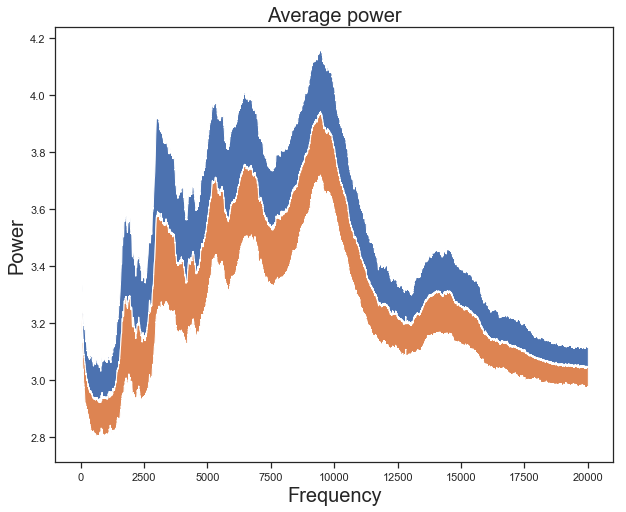

In [72]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.fill_between([i for i in range(len(PSD_vec[0]))],np.mean(PSD_vec,0),np.mean(PSD_vec,0)+np.std(PSD_vec,0))
ax.fill_between([i for i in range(len(PSD_vec[0]))],np.mean(PSD_vec,0),np.mean(PSD_vec,0)-np.std(PSD_vec,0))
ax.set_xlabel("Frequency",fontsize=20)
ax.set_ylabel("Power",fontsize=20)
ax.set_title("Average power",fontsize=20)

### Average PSDs for various time classes

As we see, the variation in the sepctrum of the signal is actually quite substantial. It might be useful to group the PSDs into classes defined by the time to event. We will use 9 such classes.

In [75]:
S0=[] #t<0.35 - 0.35 is approximate time, where we expect a boundary between two classes of time series
S1=[] #0.35<t<2
S2=[] #2<t<3
S3=[] #3<t<4
S4=[] #4<t<5
S5=[] #5<t<6
S6=[] #6<t<7
S7=[] #7<t<8
S8=[] #8<t


#We group the PSDs
for i in range(N):
    if T[i]<0.35:
        S0.append(logPSD(P[i])[:f_lim])
    elif T[i]<2:
        S1.append(logPSD(P[i])[:f_lim])
    elif T[i]<3:
        S2.append(logPSD(P[i])[:f_lim])
    elif T[i]<4:
        S3.append(logPSD(P[i])[:f_lim])
    elif T[i]<5:
        S4.append(logPSD(P[i])[:f_lim])
    elif T[i]<6:
        S5.append(logPSD(P[i])[:f_lim])
    elif T[i]<7:
        S6.append(logPSD(P[i])[:f_lim])
    elif T[i]<8:
        S7.append(logPSD(P[i])[:f_lim])
    else:
        S8.append(logPSD(P[i])[:f_lim])

S0=np.array(S0)
S1=np.array(S1)
S2=np.array(S2)
S3=np.array(S3)
S4=np.array(S4)
S5=np.array(S5)
S6=np.array(S6)
S7=np.array(S7)
S8=np.array(S8)

Text(0.5, 1.0, 'Average power per class')

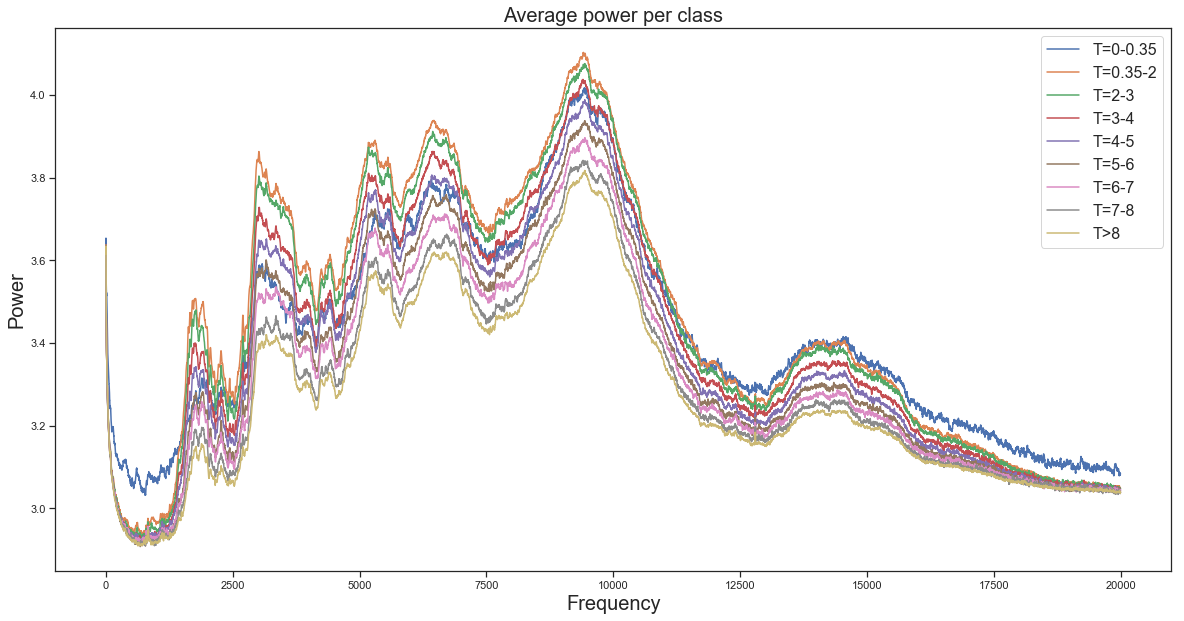

In [78]:
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(111)
ax.plot(np.mean(S0,0),label="T=0-0.35")
ax.plot(np.mean(S1,0),label="T=0.35-2")
ax.plot(np.mean(S2,0),label="T=2-3")
ax.plot(np.mean(S3,0),label="T=3-4")
ax.plot(np.mean(S4,0),label="T=4-5")
ax.plot(np.mean(S5,0),label="T=5-6")
ax.plot(np.mean(S6,0),label="T=6-7")
ax.plot(np.mean(S7,0),label="T=7-8")
ax.plot(np.mean(S8,0),label="T>8")
ax.legend(fontsize=16)
ax.set_xlabel("Frequency",fontsize=20)
ax.set_ylabel("Power",fontsize=20)
ax.set_title("Average power per class",fontsize=20)

Interestingly, we observe that at low and higher frequencies there's more power for very small T, while for larger T the differences are more pronounced at medium frequencies. It might therefore be beneficial to calculate rms of those PSDs at different frequency ranges. First, let's see if normalization helps in any way (with respect to mean of all PSDs).

In [80]:
PSDs_allmean=np.mean(np.concatenate((S0,S1,S2,S3,S4,S5,S6,S7,S8)),0)

Text(0.5, 1.0, 'Average power per class')

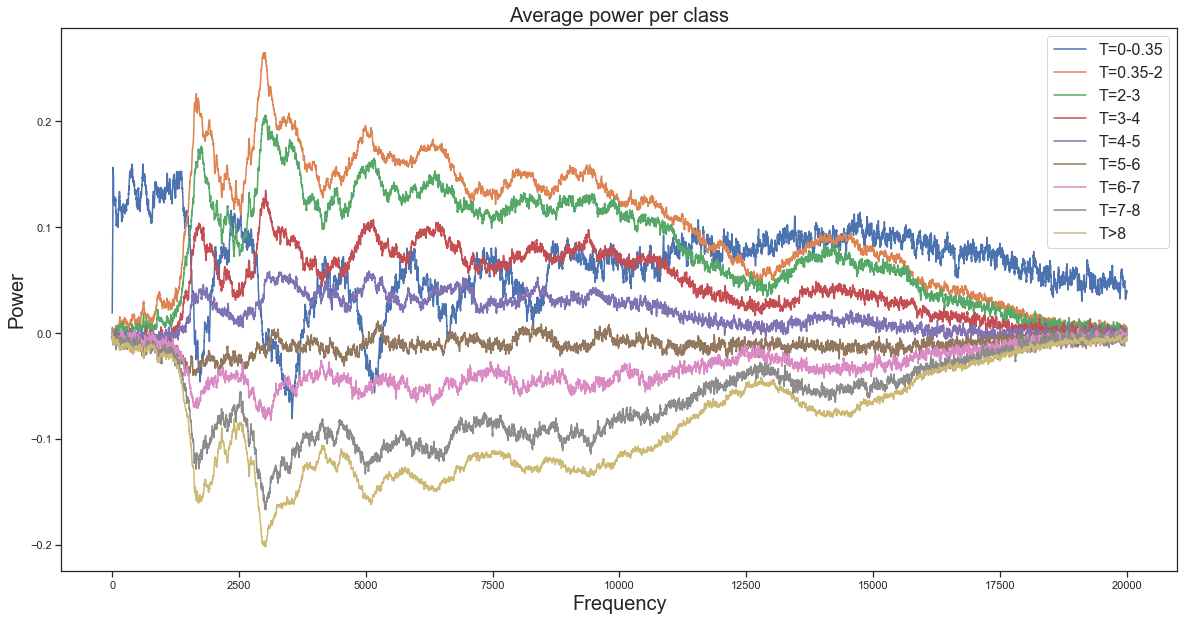

In [81]:
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(111)
ax.plot(np.mean(S0,0)-PSDs_allmean,label="T=0-0.35")
ax.plot(np.mean(S1,0)-PSDs_allmean,label="T=0.35-2")
ax.plot(np.mean(S2,0)-PSDs_allmean,label="T=2-3")
ax.plot(np.mean(S3,0)-PSDs_allmean,label="T=3-4")
ax.plot(np.mean(S4,0)-PSDs_allmean,label="T=4-5")
ax.plot(np.mean(S5,0)-PSDs_allmean,label="T=5-6")
ax.plot(np.mean(S6,0)-PSDs_allmean,label="T=6-7")
ax.plot(np.mean(S7,0)-PSDs_allmean,label="T=7-8")
ax.plot(np.mean(S8,0)-PSDs_allmean,label="T>8")
ax.legend(fontsize=16)
ax.set_xlabel("Frequency",fontsize=20)
ax.set_ylabel("Power",fontsize=20)
ax.set_title("Average power per class",fontsize=20)

We see that the differneces are quite large. Especially the T<0.35 shows a totally different frequency behavior. Let's try looking at PSDs at different parts of the spectrum. We will do that in steps of 2000. First, without mean subtraction.

In [98]:
f_step=2000

Step_PSDs=np.zeros((N_sample,10))
Step_PSDs_meansub=np.zeros((N_sample,10))

for i in range(N_sample):
    for j in range(10):
        Step_PSDs[i,j]=np.mean(PSD_vec[i,f_step*j:f_step*(j+1)])
        Step_PSDs_meansub[i,j]=np.mean(PSD_vec[i,f_step*j:f_step*(j+1)]-PSDs_allmean[f_step*j:f_step*(j+1)])

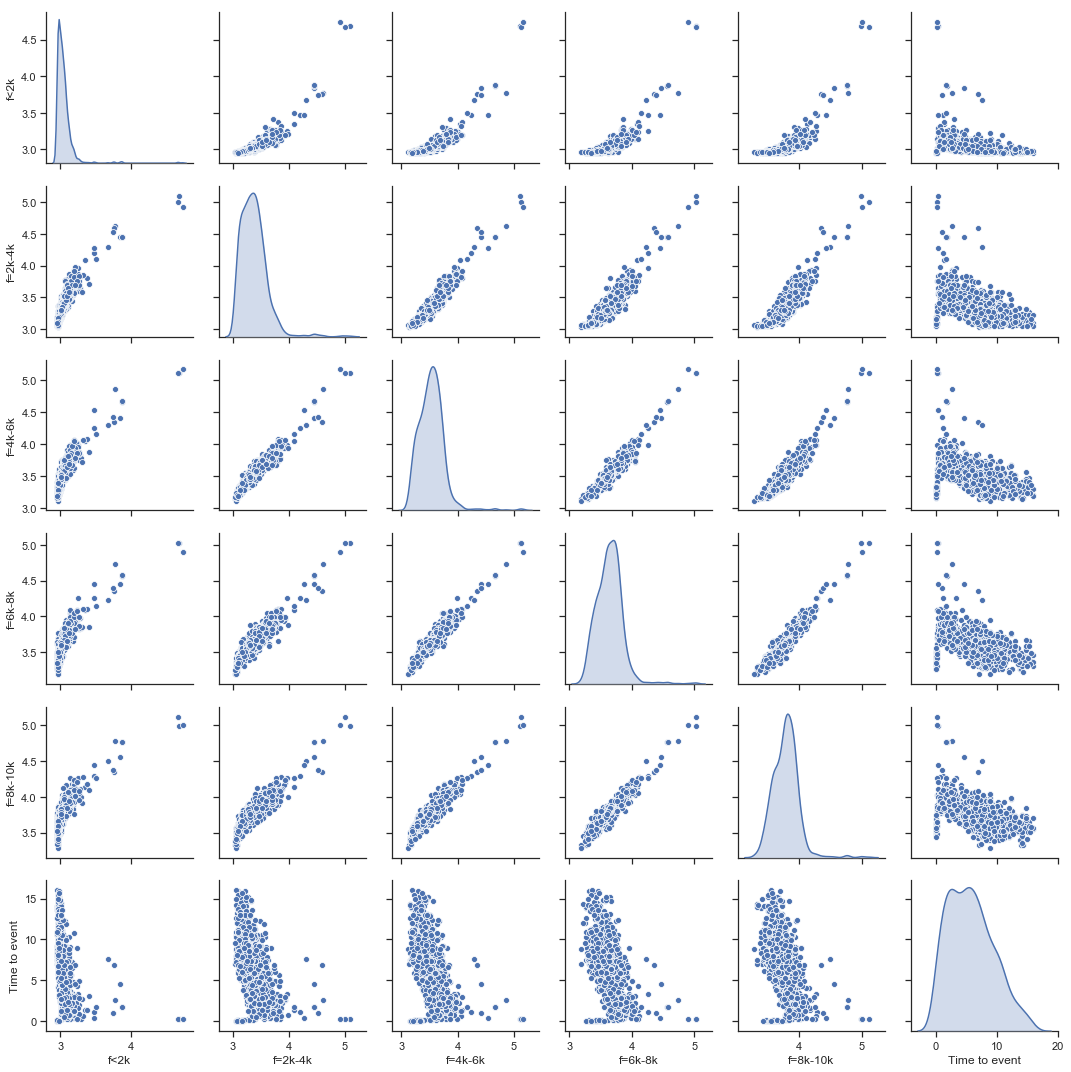

In [99]:
d = {"f<2k":Step_PSDs[:,0],"f=2k-4k":Step_PSDs[:,1],"f=4k-6k":Step_PSDs[:,2],"f=6k-8k":Step_PSDs[:,3],"f=8k-10k":Step_PSDs[:,4],"Time to event":T_sample}
df = pd.DataFrame(data=d)
g=sns.pairplot(df,diag_kind="kde")

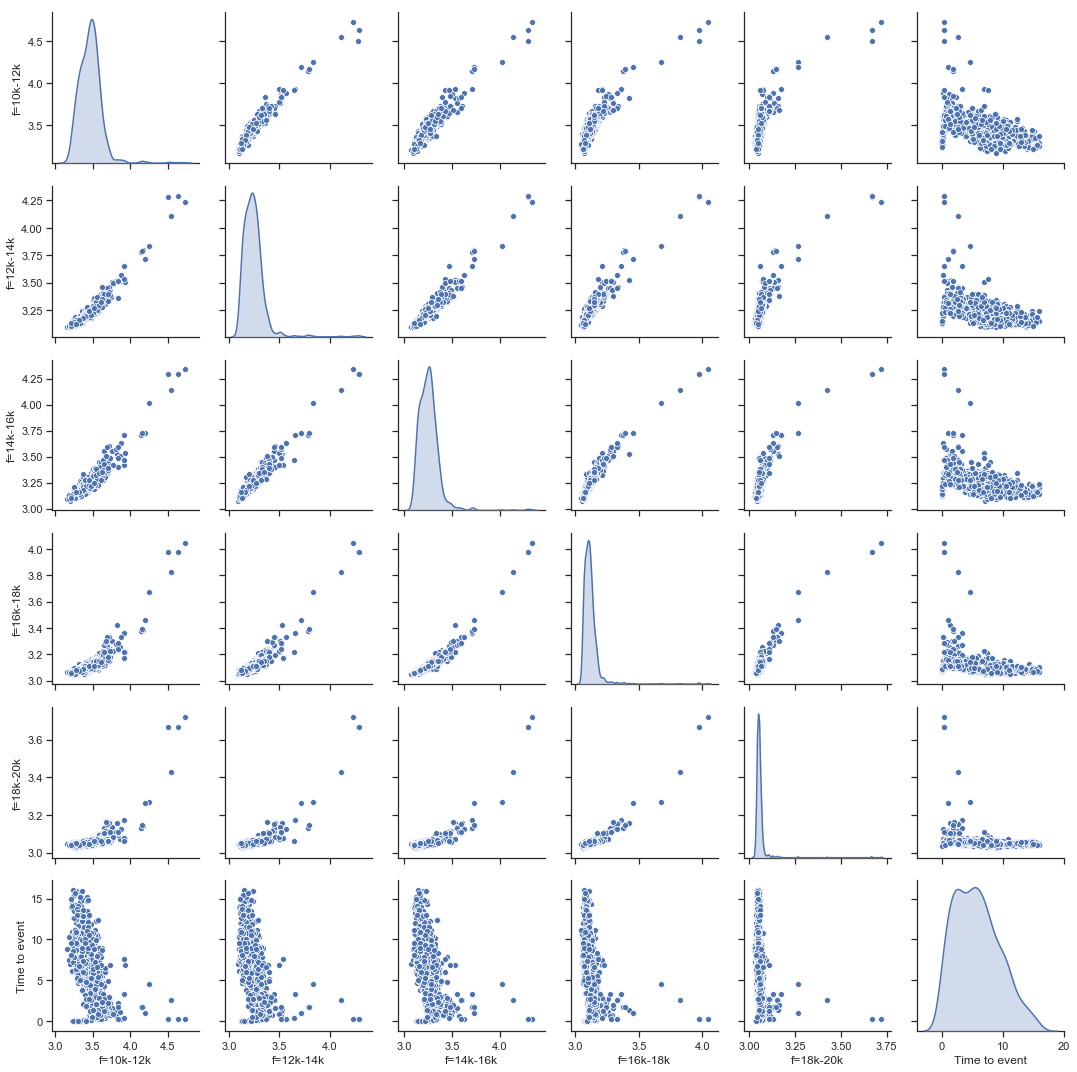

In [100]:
d = {"f=10k-12k":Step_PSDs[:,5],"f=12k-14k":Step_PSDs[:,6],"f=14k-16k":Step_PSDs[:,7],"f=16k-18k":Step_PSDs[:,8],"f=18k-20k":Step_PSDs[:,9],"Time to event":T_sample}
df = pd.DataFrame(data=d)
g=sns.pairplot(df,diag_kind="kde")

Most of those seem pretty well correlated with T. What if subtract the mean?

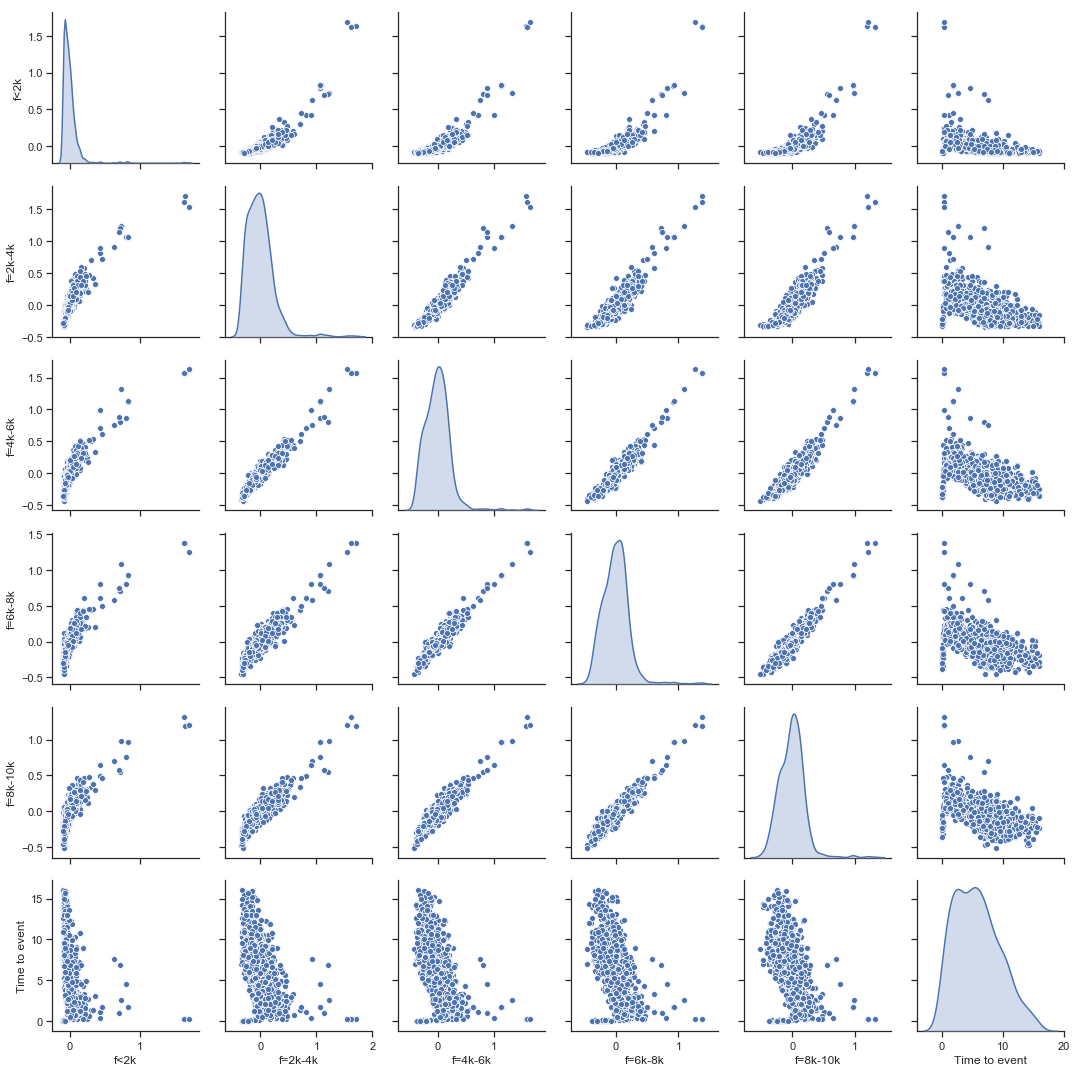

In [101]:
d = {"f<2k":Step_PSDs_meansub[:,0],"f=2k-4k":Step_PSDs_meansub[:,1],"f=4k-6k":Step_PSDs_meansub[:,2],"f=6k-8k":Step_PSDs_meansub[:,3],"f=8k-10k":Step_PSDs_meansub[:,4],"Time to event":T_sample}
df = pd.DataFrame(data=d)
g=sns.pairplot(df,diag_kind="kde")

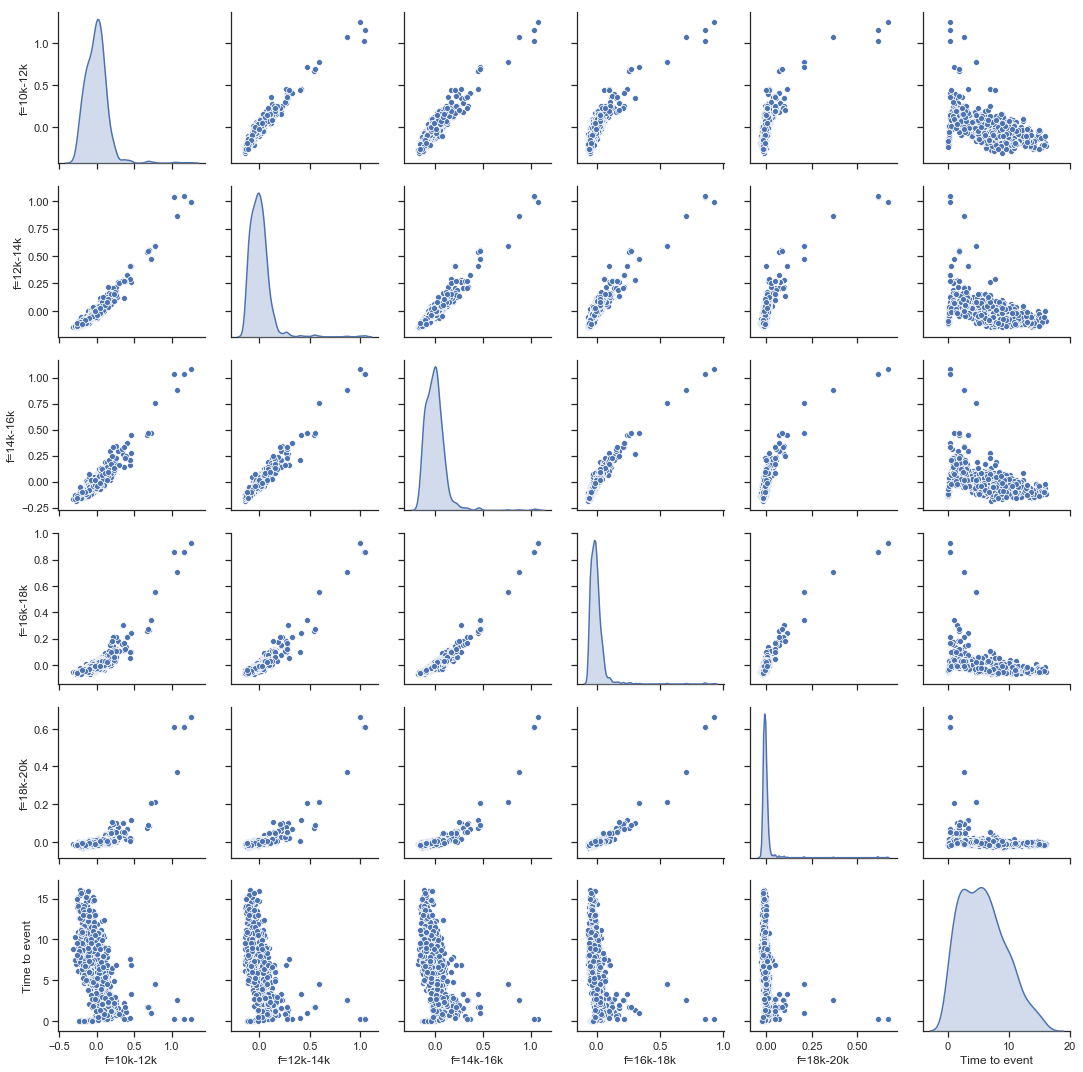

In [102]:
d = {"f=10k-12k":Step_PSDs_meansub[:,5],"f=12k-14k":Step_PSDs_meansub[:,6],"f=14k-16k":Step_PSDs_meansub[:,7],"f=16k-18k":Step_PSDs_meansub[:,8],"f=18k-20k":Step_PSDs_meansub[:,9],"Time to event":T_sample}
df = pd.DataFrame(data=d)
g=sns.pairplot(df,diag_kind="kde")

Both methods seem equally good, so for simplicity, we won't subtract the mean. Let's also look smallest and highest frequencies and how they define two time classes.

In [111]:
Low_freq_PSD0=np.mean(S0[:,:f_step],1)
High_freq_PSD0=np.mean(S0[:,9*f_step:10*f_step],1)

S18=np.concatenate((S1,S2,S3,S4,S5,S6,S7,S8))

Low_freq_PSD18=np.mean(S18[:,:f_step],1)
High_freq_PSD18=np.mean(S18[:,9*f_step:10*f_step],1)

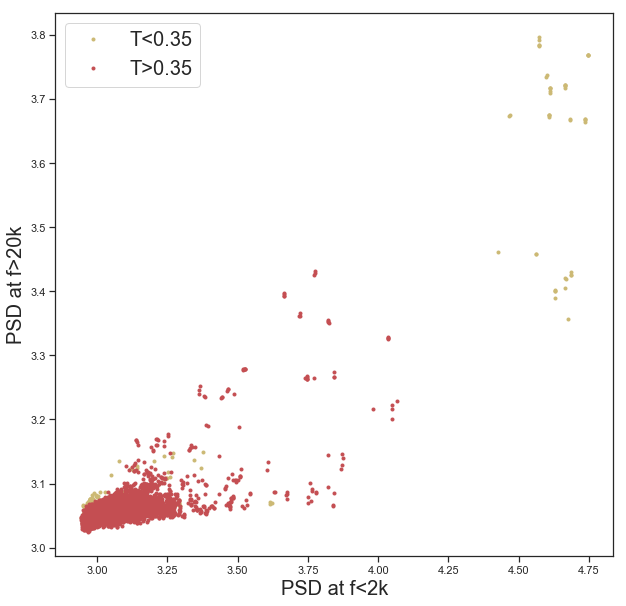

In [116]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
ax.plot(Low_freq_PSD0,High_freq_PSD0,'y.',label='T<0.35')
ax.plot(Low_freq_PSD18,High_freq_PSD18,'r.',label='T>0.35')
ax.set_xlabel('PSD at f<2k',fontsize=20)
ax.set_ylabel('PSD at f>20k',fontsize=20)
ax.legend(fontsize=20,loc=0)

Clearly, this set is linearly separable to some degree. There are some yellow (T<0.35) points very close to red points, but the whole upper-right corner can be clearly assigned a label with no error.

---

## Wavelet

Another idea is to convolve the signal with some characteristic frequency response and look at the obtained value. We have observed that the most interesting frequencies appear at f=4000-1000. Let's see how a signal made from those frequencies and average PSD would look like. Note, that the wavelet is refered here to us as "chirplet", which is not exactly correct - chirplets are frequency-modulated.

In [141]:
PSD_chirp=PSDs_allmean[4000:10000]

Chirp=np.power(10,PSD_chirp)
Chirp[0]=1
Chirp=np.fft.irfft(Chirp) #We can obtain the time-domain signal by apply inverse FFT

Chirp=np.concatenate((Chirp[int(len(Chirp)/2):],Chirp[:int(len(Chirp)/2)])) #Symmetrization

Chirp=Chirp[int(len(Chirp)/2)-15:int(len(Chirp)/2)+15] #Extraction of the non-trivial part

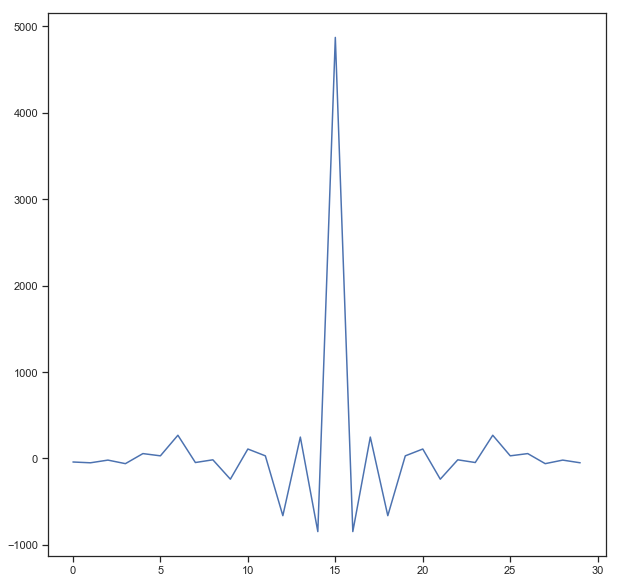

In [142]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
ax.plot(Chirp)

Alternatively, we can create a chirplet "by hand" by selecting frequencies that play a major role in the signal. Frequencies oj major importance seem to appear at f=1k (to distinguish T<0.35), 2k, 3k, 5.25k, 6.5k, 9.4k. To make a shorter signal, we change the frequency range from 75k to 500.

In [185]:
p_1k=PSDs_allmean[1000]
p_2k=PSDs_allmean[2000]
p_3k=PSDs_allmean[3000]
p_5k=PSDs_allmean[5250]
p_6k=PSDs_allmean[6500]
p_9k=PSDs_allmean[9400]

c_1k=1000/75000*500
c_2k=2000/75000*500
c_3k=3000/75000*500
c_5k=5200/75000*500
c_6k=6500/75000*500
c_9k=9400/75000*500

peaks=[p_1k,p_2k,p_3k,p_5k,p_6k,p_9k]
centers=[c_1k,c_2k,c_3k,c_5k,c_6k,c_9k]

In [196]:
fs=np.arange(500)
artificial_signal=0
for i in range(6):
    artificial_signal+=peaks[i]*np.exp(-(fs-centers[i])**2/10)

Text(0, 0.5, 'PSD')

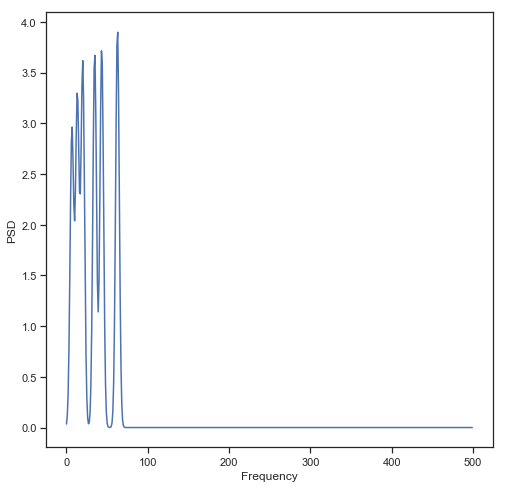

In [197]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.plot(artificial_signal)
ax.set_xlabel('Frequency')
ax.set_ylabel('PSD')

In [198]:
artificial_chirp=np.power(10,artificial_signal)
artificial_chirp[0]=1
artificial_chirp=np.fft.irfft(artificial_chirp)
artificial_chirp=np.concatenate((artificial_chirp[499:],artificial_chirp[:499]))

Text(0.5, 1.0, 'Artificial chirplet')

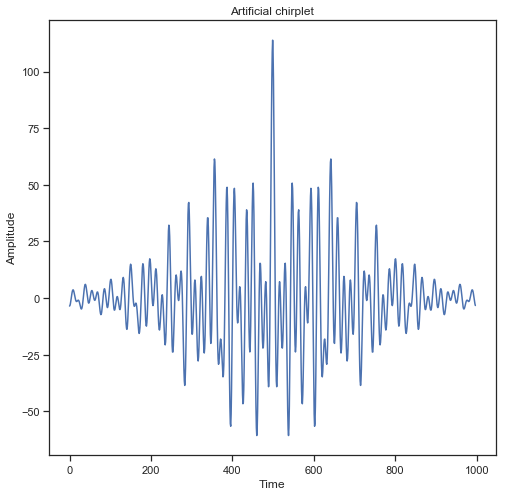

In [200]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.plot(artificial_chirp)
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
ax.set_title('Artificial chirplet')

We can now compare both chirplets. First, let's again divide the time-series into time classes and calculate their means

In [140]:
P0=[] #t<0.35 - 0.35 is approximate time, where we expect a boundary between two classes of time series
P1=[] #0.35<t<2
P2=[] #2<t<3
P3=[] #3<t<4
P4=[] #4<t<5
P5=[] #5<t<6
P6=[] #6<t<7
P7=[] #7<t<8
P8=[] #8<t


#We group the PSDs
for i in range(N):
    if T[i]<0.35:
        P0.append(P[i])
    elif T[i]<2:
        P1.append(P[i])
    elif T[i]<3:
        P2.append(P[i])
    elif T[i]<4:
        P3.append(P[i])
    elif T[i]<5:
        P4.append(P[i])
    elif T[i]<6:
        P5.append(P[i])
    elif T[i]<7:
        P6.append(P[i])
    elif T[i]<8:
        P7.append(P[i])
    else:
        P8.append(P[i])

P0=np.array(P0)
P1=np.array(P1)
P2=np.array(P2)
P3=np.array(P3)
P4=np.array(P4)
P5=np.array(P5)
P6=np.array(P6)
P7=np.array(P7)
P8=np.array(P8)

P0_mean=np.mean(P0,0)
P1_mean=np.mean(P1,0)
P2_mean=np.mean(P2,0)
P3_mean=np.mean(P3,0)
P4_mean=np.mean(P4,0)
P5_mean=np.mean(P5,0)
P6_mean=np.mean(P6,0)
P7_mean=np.mean(P7,0)
P8_mean=np.mean(P8,0)

We first convolve the time signal with both chirplets, after which we take the absolute value and smooth the signal with 1000-point moving average, and finally take log base 10. 

Text(0.5, 1.0, 'Convolution with artificial chirplet')

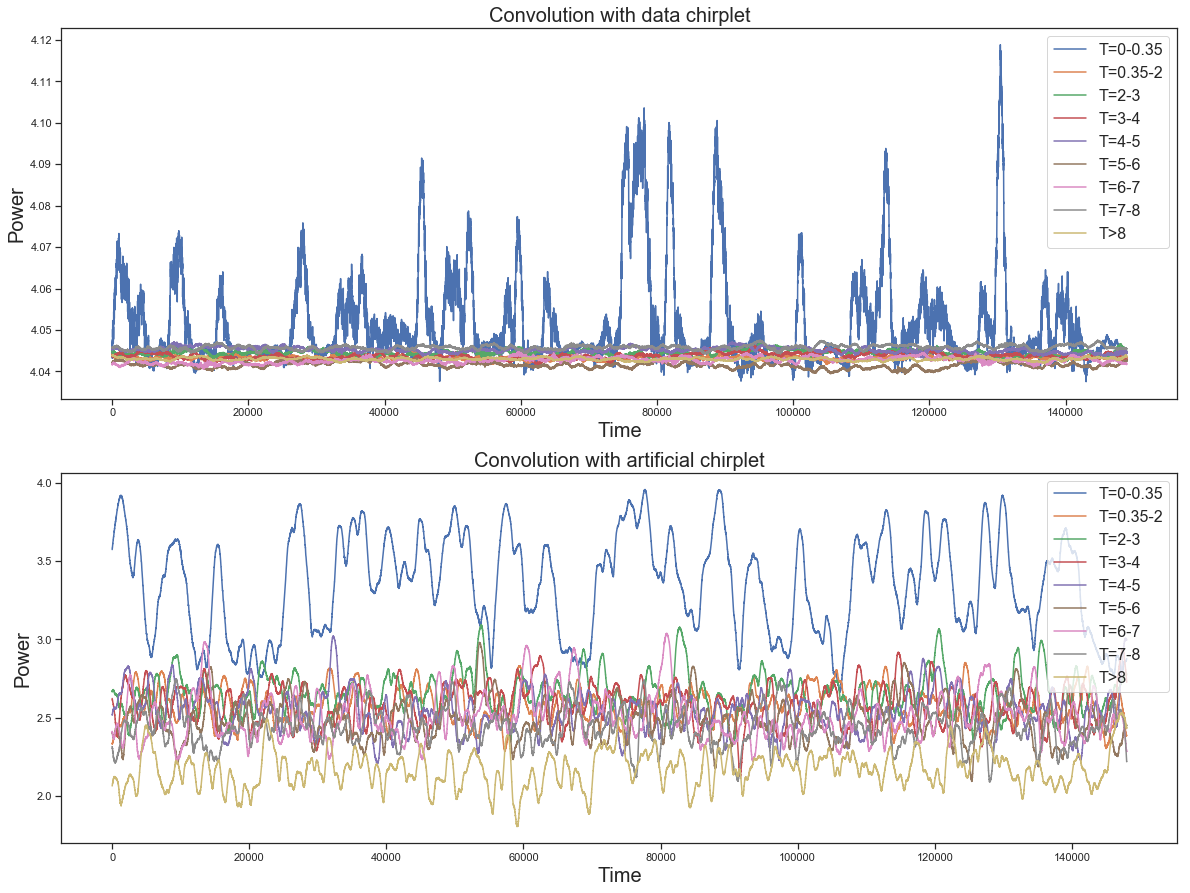

In [210]:
fig=plt.figure(figsize=(20,15))
ax=fig.add_subplot(211)
ax.plot(np.log10(MA(np.absolute(np.convolve(P0_mean,Chirp,'valid')),N=1000)),label="T=0-0.35")
ax.plot(np.log10(MA(np.absolute(np.convolve(P1_mean,Chirp,'valid')),N=1000)),label="T=0.35-2")
ax.plot(np.log10(MA(np.absolute(np.convolve(P2_mean,Chirp,'valid')),N=1000)),label="T=2-3")
ax.plot(np.log10(MA(np.absolute(np.convolve(P3_mean,Chirp,'valid')),N=1000)),label="T=3-4")
ax.plot(np.log10(MA(np.absolute(np.convolve(P4_mean,Chirp,'valid')),N=1000)),label="T=4-5")
ax.plot(np.log10(MA(np.absolute(np.convolve(P5_mean,Chirp,'valid')),N=1000)),label="T=5-6")
ax.plot(np.log10(MA(np.absolute(np.convolve(P6_mean,Chirp,'valid')),N=1000)),label="T=6-7")
ax.plot(np.log10(MA(np.absolute(np.convolve(P7_mean,Chirp,'valid')),N=1000)),label="T=7-8")
ax.plot(np.log10(MA(np.absolute(np.convolve(P8_mean,Chirp,'valid')),N=1000)),label="T>8")
ax.legend(fontsize=16)
ax.set_xlabel("Time",fontsize=20)
ax.set_ylabel("Power",fontsize=20)
ax.set_title("Convolution with data chirplet",fontsize=20)

ax=fig.add_subplot(212)
ax.plot(np.log10(MA(np.absolute(np.convolve(P0_mean,artificial_chirp,'valid')),N=1000)),label="T=0-0.35")
ax.plot(np.log10(MA(np.absolute(np.convolve(P1_mean,artificial_chirp,'valid')),N=1000)),label="T=0.35-2")
ax.plot(np.log10(MA(np.absolute(np.convolve(P2_mean,artificial_chirp,'valid')),N=1000)),label="T=2-3")
ax.plot(np.log10(MA(np.absolute(np.convolve(P3_mean,artificial_chirp,'valid')),N=1000)),label="T=3-4")
ax.plot(np.log10(MA(np.absolute(np.convolve(P4_mean,artificial_chirp,'valid')),N=1000)),label="T=4-5")
ax.plot(np.log10(MA(np.absolute(np.convolve(P5_mean,artificial_chirp,'valid')),N=1000)),label="T=5-6")
ax.plot(np.log10(MA(np.absolute(np.convolve(P6_mean,artificial_chirp,'valid')),N=1000)),label="T=6-7")
ax.plot(np.log10(MA(np.absolute(np.convolve(P7_mean,artificial_chirp,'valid')),N=1000)),label="T=7-8")
ax.plot(np.log10(MA(np.absolute(np.convolve(P8_mean,artificial_chirp,'valid')),N=1000)),label="T>8")
ax.legend(fontsize=16)
ax.set_xlabel("Time",fontsize=20)
ax.set_ylabel("Power",fontsize=20)
ax.set_title("Convolution with artificial chirplet",fontsize=20)

Both chirplets seem to decently distinguish between T<0.35 and T>0.35. The data chirplet seems like a very good predictor of this time class. The artificial wavelet seems to also provide some information about T>8 class. Let's check sum of the whole convolution.

In [211]:
chirp_conv=np.zeros((N_sample,))
art_chirp_conv=np.zeros((N_sample,))
for i in range(N_sample):
    chirp_conv[i]=np.log10(np.sum(np.absolute(np.convolve(P_sample[i],Chirp,'valid'))))
    art_chirp_conv[i]=np.log10(np.sum(np.absolute(np.convolve(P_sample[i],artificial_chirp,'valid'))))

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Convolution with artificial chirplet')

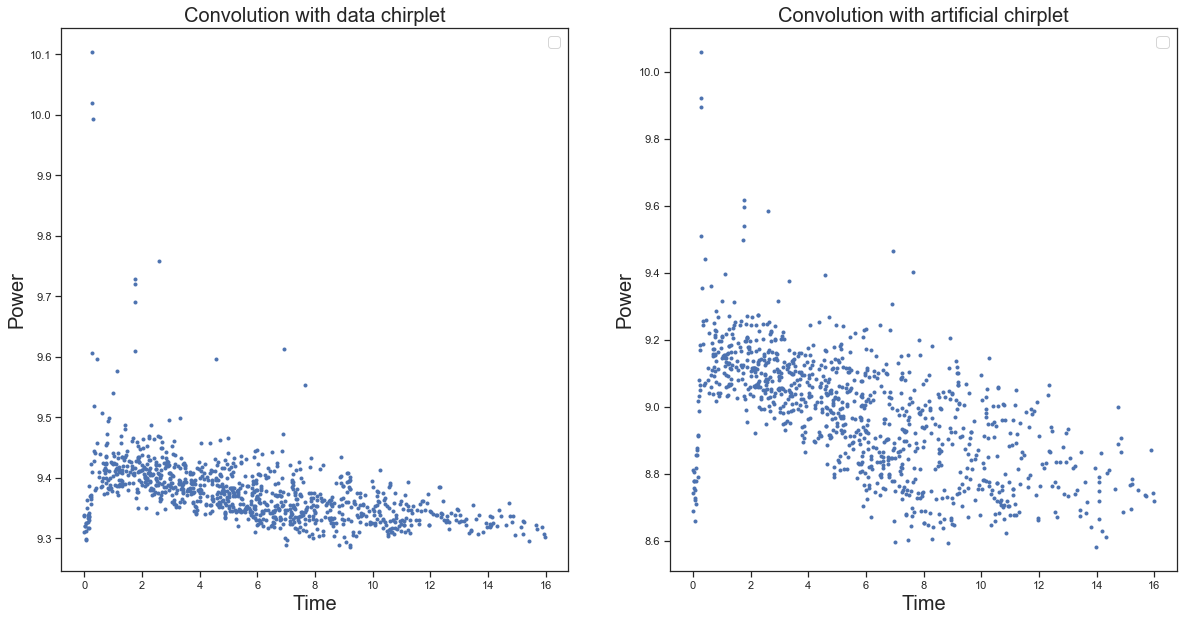

In [212]:
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(121)
ax.plot(T_sample,chirp_conv,'.')
ax.legend(fontsize=16)
ax.set_xlabel("Time",fontsize=20)
ax.set_ylabel("Power",fontsize=20)
ax.set_title("Convolution with data chirplet",fontsize=20)
ax=fig.add_subplot(122)
ax.plot(T_sample,art_chirp_conv,'.')
ax.legend(fontsize=16)
ax.set_xlabel("Time",fontsize=20)
ax.set_ylabel("Power",fontsize=20)
ax.set_title("Convolution with artificial chirplet",fontsize=20)

Both methods lead to very similar results. What about mean values?

In [213]:
chirp_conv_mean=np.zeros((N_sample,))
art_chirp_conv_mean=np.zeros((N_sample,))
for i in range(N_sample):
    chirp_conv_mean[i]=np.mean(np.log10(np.absolute(np.convolve(P_sample[i],Chirp,'valid'))))
    art_chirp_conv_mean[i]=np.mean(np.log10(np.absolute(np.convolve(P_sample[i],artificial_chirp,'valid'))))

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Convolution with artificial chirplet')

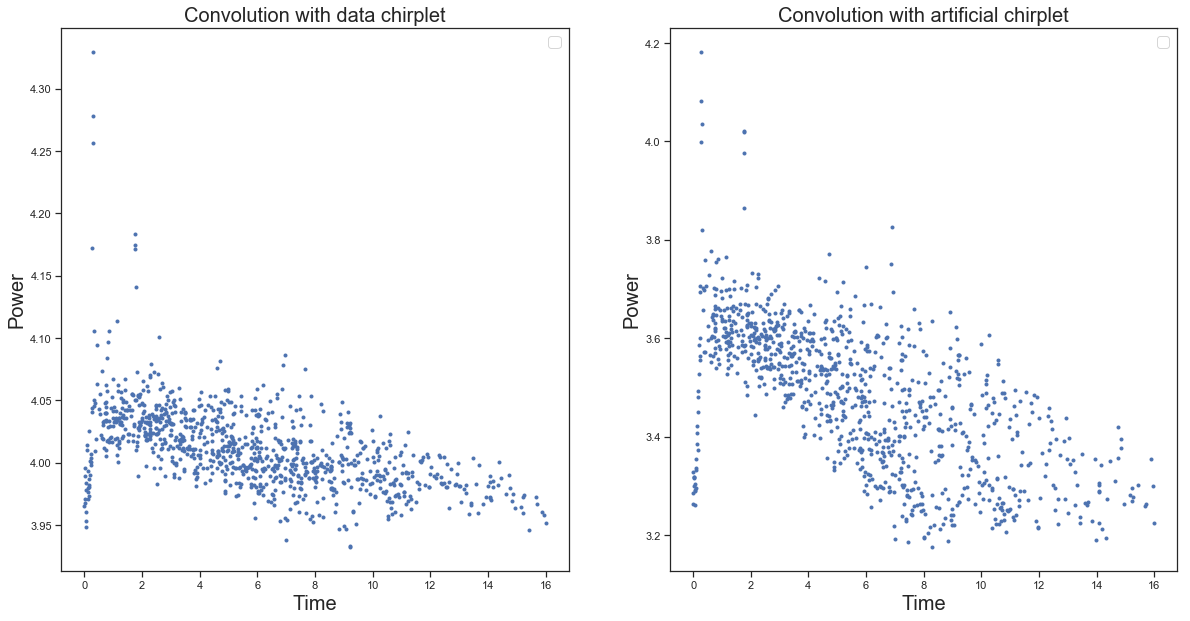

In [214]:
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(121)
ax.plot(T_sample,chirp_conv_mean,'.')
ax.legend(fontsize=16)
ax.set_xlabel("Time",fontsize=20)
ax.set_ylabel("Power",fontsize=20)
ax.set_title("Convolution with data chirplet",fontsize=20)
ax=fig.add_subplot(122)
ax.plot(T_sample,art_chirp_conv_mean,'.')
ax.legend(fontsize=16)
ax.set_xlabel("Time",fontsize=20)
ax.set_ylabel("Power",fontsize=20)
ax.set_title("Convolution with artificial chirplet",fontsize=20)

Both of these seem to behave just like sums. The last thing we will check is number of peaks above certain value. Threshold values are arbitrary and chosen by looking at convolutions shown before for different time classes.

In [228]:
chirp_conv_peak=np.zeros((N_sample,))
art_chirp_conv_peak=np.zeros((N_sample,))
for i in range(N_sample):
    chirp_conv_peak[i]=peak_no(np.log10(MA(np.absolute(np.convolve(P_sample[i],Chirp,'valid')),N=1000)),4.15)
    art_chirp_conv_peak[i]=peak_no(np.log10(MA(np.absolute(np.convolve(P_sample[i],artificial_chirp,'valid')),N=1000)),3.65)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Convolution with artificial chirplet')

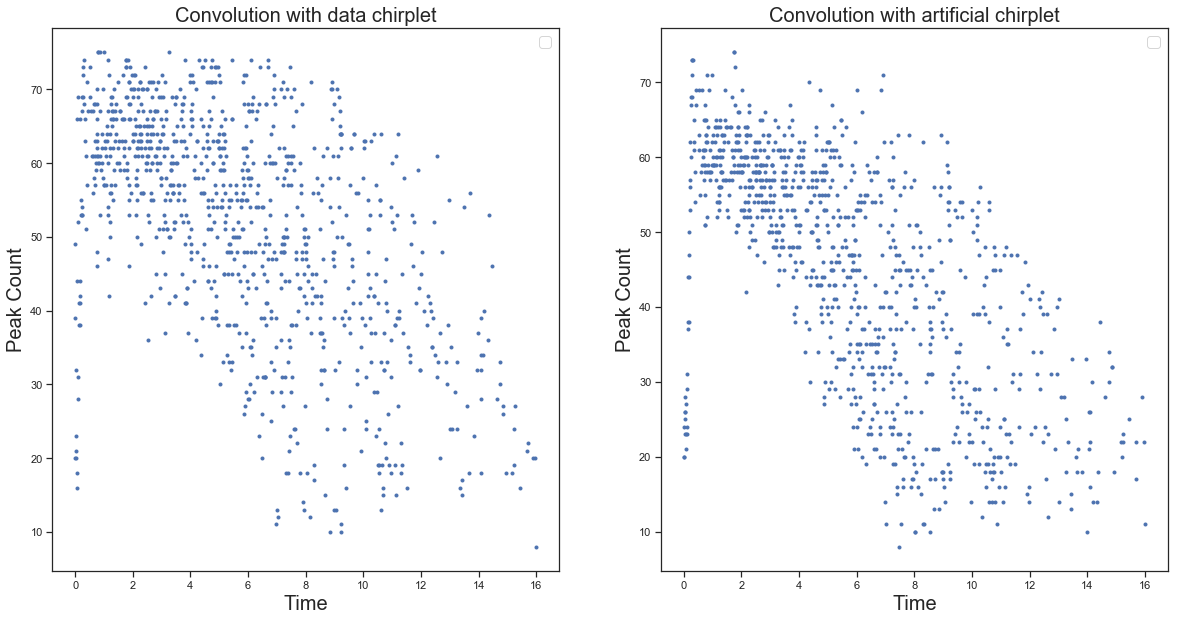

In [229]:
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(121)
ax.plot(T_sample,chirp_conv_peak,'.')
ax.legend(fontsize=16)
ax.set_xlabel("Time",fontsize=20)
ax.set_ylabel("Peak Count",fontsize=20)
ax.set_title("Convolution with data chirplet",fontsize=20)
ax=fig.add_subplot(122)
ax.plot(T_sample,art_chirp_conv_peak,'.')
ax.legend(fontsize=16)
ax.set_xlabel("Time",fontsize=20)
ax.set_ylabel("Peak Count",fontsize=20)
ax.set_title("Convolution with artificial chirplet",fontsize=20)

---

## Saving chosen parameters

In the end, the best parameters to extract from these time-series are:
- standard deviation and the extremum
- total rms "power" in power spectrum density
- power at frequencies of 1000:2000:19000
- average power at [i,i+2000] ranges for i=0:2000:18000
- mean of convolution with both chirplets
- number of peaks in the convolution at chosen thresholds

In total that gives us 2+1+10+10+2+2=27 parameters. Additionally, we save the data chirplet.

In [231]:
Params=np.zeros((N,27))
for i in range(N):
    
    Params[i,0]=np.std(P[i])
    Params[i,1]=extr(P[i])
    
    P_psd=logPSD(P[i])
    
    Params[i,2]=rms(P_psd)
    
    for j in range(10):
        Params[i,j+3]=P_psd[1000+j*2000]
        
    for j in range(10):
        Params[i,j+13]=np.mean(P_psd[j*2000:(j+1)*2000])
        
    Params[i,23]=np.mean(np.log10(np.absolute(np.convolve(P[i],Chirp,'valid'))))
    Params[i,24]=np.mean(np.log10(np.absolute(np.convolve(P[i],artificial_chirp,'valid'))))
    Params[i,25]=peak_no(np.log10(MA(np.absolute(np.convolve(P[i],Chirp,'valid')),N=1000)),4.15)
    Params[i,26]=peak_no(np.log10(MA(np.absolute(np.convolve(P[i],artificial_chirp,'valid')),N=1000)),3.65)

In [232]:
f=h5py.File("full_params.hdf5","w")
f.create_dataset('Parameters',data=Params)
f.create_dataset("Time",data=T)
f.create_dataset("Wavelet",data=Chirp)
f.create_dataset("Artificial_wavelet",data=artificial_chirp)
f.close()

We also create a dataset with normalized parameters, i.e. (parameter-mean)/std.

In [233]:
ParamsN=np.zeros((N,27))
for k in range(27):
    ParamsN[:,k]=normalize(Params[:,k])

In [234]:
f=h5py.File("norm_params.hdf5","w")
f.create_dataset('Parameters',data=ParamsN)
f.create_dataset("Time",data=T)
f.create_dataset("Wavelet",data=Chirp)
f.create_dataset("Artificial_wavelet",data=artificial_chirp)
f.close()

fw.close() #The samples file